In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import cv2
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers, regularizers
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from scipy import misc, ndimage
from IPython.display import display, HTML
import time
from google.colab import drive
drive.mount('/content/drive')


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pwd

/content


In [0]:
#获取当前日期：time.time()
TB_name = "shi_detect_VGG-16-{}".format(int(time.time()))

In [0]:
#TensorBoard会自动包括所有记录在指定log/子目录中的运行
call_tensorboard = keras.callbacks.TensorBoard(log_dir='logs/{}'.format(TB_name))
#write_graph=True, write_images=True

In [0]:
os.environ['PYTHONHASHSEED'] = '0' 
np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)
#tf.set_random_seed(10)

In [0]:
def plots(ims, figsize = (12,6), rows = 1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [0]:
DATADIR = "/content/drive/'My Drive'/ship/images"
#categories1 = ["cargo_RGB", "dredging_RGB",  "fishing_RGB",  "tanker_RGB",  "tug_RGB"]
categories = ["cargo", "tanker", "others"]

In [8]:
!ls /content/

drive  sample_data


In [0]:
#!ls /content/drive/'My Drive'/vgg/ship
#!ls /content/drive/'My Drive'/vgg/ship/images
#!ls /content/drive/'My Drive'/vgg/ship/images/train
#!ls /content/drive/'My Drive'/vgg/ship/images/train/cargo


In [0]:
#train_path = '/content/drive/My Drive/vgg/dataset3/ship/images/train'
#valid_path = '/content/drive/My Drive/vgg/dataset3/ship/images/valid'
#test_path = '/content/drive/My Drive/vgg/dataset3/ship/images/test'

In [0]:
train_path = '/content/drive/My Drive/ship/images/train'
valid_path = '/content/drive/My Drive/ship/images/valid'
test_path = '/content/drive/My Drive/ship/images/test'

In [11]:
train_path

'/content/drive/My Drive/ship/images/train'

In [12]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (224, 224), color_mode='rgb', classes = categories, batch_size = 2, shuffle=True)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (224, 224), color_mode='rgb',  classes = categories, batch_size = 2, shuffle=True)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224, 224),  color_mode='rgb', classes = categories, batch_size = 200, shuffle=True)

#!ls /content/drive/'My Drive'/vgg/ship/images/train/cargo
class_labels = valid_batches.class_indices
print('class labels are:', class_labels)

Found 600 images belonging to 3 classes.
Found 200 images belonging to 3 classes.
Found 200 images belonging to 3 classes.
class labels are: {'cargo': 0, 'tanker': 1, 'others': 2}


In [13]:
test_imgs, test_labels = next(test_batches)
class_labels = test_batches.class_indices
class_labels
print(test_labels.shape)
print(test_imgs.shape)
print(test_batches)

(200, 3)
(200, 224, 224, 3)


In [14]:
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

553467904/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [15]:
type(vgg16_model)

keras.engine.training.Model

In [0]:
layers = []
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False
    layers.append(layer)

model = Sequential(layers + [
    Conv2D(filters = 512, kernel_size = (7, 7), activation = 'relu'),
    #Conv2D(filters = 512, kernel_size = (4,4), activation = 'relu'),
    Flatten(),
    BatchNormalization(),
    Dense(4096, activation='relu'),
    Dense(2048, activation = 'relu'),
    Dropout(0.2),
    Dense(3, activation = 'softmax')
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [0]:
Adam = optimizers.Adam(lr=0.0001)
#Adam = optimizers.Adam(lr=0.0001)
#lr：float> = 0   学习率。
# 传入优化器名称: 默认参数将被采用
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit_generator(train_batches,
                   validation_data = valid_batches,
                   shuffle = True,
                   callbacks = [call_tensorboard],  
                   epochs = 40,
                   verbose = 1)

Epoch 1/40
300/300 [==============================] - 247s 822ms/step - loss: 1.1424 - accuracy: 0.6383 - val_loss: 0.0932 - val_accuracy: 0.7200
Epoch 2/40
300/300 [==============================] - 9s 32ms/step - loss: 0.8486 - accuracy: 0.6817 - val_loss: 0.1405 - val_accuracy: 0.6700
Epoch 3/40
300/300 [==============================] - 9s 32ms/step - loss: 0.9673 - accuracy: 0.6583 - val_loss: 1.3817 - val_accuracy: 0.7150
Epoch 4/40
300/300 [==============================] - 9s 31ms/step - loss: 0.8918 - accuracy: 0.6633 - val_loss: 0.5541 - val_accuracy: 0.7300
Epoch 5/40
300/300 [==============================] - 9s 31ms/step - loss: 0.8573 - accuracy: 0.6817 - val_loss: 0.9783 - val_accuracy: 0.7200
Epoch 6/40
300/300 [==============================] - 9s 31ms/step - loss: 0.8241 - accuracy: 0.7017 - val_loss: 0.3807 - val_accuracy: 0.7300
Epoch 7/40
300/300 [==============================] - 9s 31ms/step - loss: 0.7862 - accuracy: 0.7067 - val_loss: 7.4136 - val_accuracy: 0.7

In [20]:
predictions = model.predict_generator(test_batches, verbose=1) #使用模型预测 100=200(测试集200个样本)/batch_size

1/1 [==============================] - 4s 4s/step


In [21]:
CSS = """
.output{
    flex-direction: row;
    
}
"""
HTML('<style>{}</style>'.format(CSS))

In [22]:
display(predictions)
display(test_labels)

array([[9.04724300e-01, 5.88170998e-02, 3.64587195e-02],
       [4.29072827e-01, 2.99092561e-01, 2.71834582e-01],
       [5.38678050e-01, 2.27019370e-01, 2.34302580e-01],
       [3.63997634e-12, 5.14172007e-06, 9.99994874e-01],
       [4.90100181e-04, 2.16189045e-02, 9.77890968e-01],
       [9.72216070e-01, 6.42089266e-03, 2.13629957e-02],
       [2.59448051e-01, 2.75025010e-01, 4.65526909e-01],
       [9.97069836e-01, 1.06905261e-03, 1.86107575e-03],
       [9.87344921e-01, 2.00023246e-03, 1.06549123e-02],
       [9.78971839e-01, 5.23339119e-03, 1.57947186e-02],
       [8.49557638e-01, 4.20120656e-02, 1.08430244e-01],
       [9.96120989e-01, 2.72214063e-03, 1.15684420e-03],
       [5.66990852e-01, 1.95953161e-01, 2.37055972e-01],
       [6.55799210e-02, 1.91978693e-01, 7.42441416e-01],
       [5.49513102e-01, 2.37927407e-01, 2.12559447e-01],
       [4.88333628e-02, 1.66806400e-01, 7.84360230e-01],
       [9.88496065e-01, 9.17584077e-03, 2.32810341e-03],
       [8.61277282e-01, 8.90220

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0

In [23]:
def predictions_to_label_array(predictions_array):
    predictions_one_hot_encode = []
    for array in predictions_array:
        result_per__iteration = []
        for value in array:
            if value < max(array):
                result_per__iteration.append(0)
            elif value == max(array):
                result_per__iteration.append(1)
            else:
                result_per__iteration.append(0)
        predictions_one_hot_encode.append(result_per__iteration)
    return([np.where(r==1)[0][0] for r in np.array(predictions_one_hot_encode)])
prediction_label = predictions_to_label_array(predictions)
true_label = predictions_to_label_array(test_labels)

print(test_labels.shape)
print(predictions.shape)

print('{}\n{}\n{}'.format(class_labels, true_label, prediction_label))

(200, 3)
(200, 3)
{'cargo': 0, 'tanker': 1, 'others': 2}
[0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 0, 1, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2,

In [0]:
cm = confusion_matrix(true_label, prediction_label)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.show()

Confusion matrix, without normalization
[[118   4  12]
 [ 11   2  20]
 [  8   0  25]]
Confusion matrix, without normalization
[[118   4  12]
 [ 11   2  20]
 [  8   0  25]]


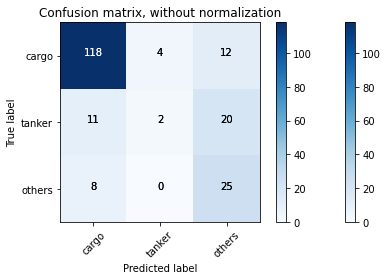

In [26]:
cm_plot_labels = categories
plot_confusion_matrix(cm, cm_plot_labels,
                          title='Confusion matrix')

plot_confusion_matrix(cm, classes=categories,
                      title='Confusion matrix, without normalization')

In [27]:
print(classification_report(true_label, prediction_label, target_names=categories))

              precision    recall  f1-score   support

       cargo       0.86      0.88      0.87       134
      tanker       0.33      0.06      0.10        33
      others       0.44      0.76      0.56        33

    accuracy                           0.73       200
   macro avg       0.54      0.57      0.51       200
weighted avg       0.70      0.72      0.69       200



In [0]:
#model.save('/content/drive/My Drive/vgg/saved_models/vgg16_model_ships.h5')#The architecture, weights, congig, state

In [0]:
#new_model = load_model('/content/drive/My Drive/vgg/saved_models/vgg16_model_ships.h5')